# Human Activity Recognition with Hidden Markov Models (HMM)

This notebook walks through: data loading, visualization, feature extraction usage, participant-aware train/test split, HMM training (Baum–Welch via `fit`) and Viterbi decoding, metrics, and plots required by the assignment.


## 1. Setup and Imports


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from hmmlearn import hmm

sns.set(style="whitegrid")


## 2. Paths and Data Overview


In [2]:
# Resolve repo-relative paths
ROOT = Path("..") if Path("..").exists() else Path(".")
MERGED_DIR = (ROOT / "data" / "merged") if (ROOT / "data" / "merged").exists() else Path("data/merged")
FEATURES_PATH = (ROOT / "data" / "features" / "features.csv") if (ROOT / "data" / "features" / "features.csv").exists() else Path("data/features/features.csv")
RESULTS_DIR = (ROOT / "results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Merged dir: {MERGED_DIR}")
print(f"Features path: {FEATURES_PATH}")
print(f"Results dir: {RESULTS_DIR}")


Merged dir: ..\data\merged
Features path: ..\data\features\features.csv
Results dir: ..\results


## 3. Visualize Raw Signals (per activity)


In [3]:
activities = ["walking", "standing", "jumping", "still"]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
for i, activity in enumerate(activities):
    file_path = MERGED_DIR / f"{activity}_merged.csv"
    if not file_path.exists():
        print(f" File not found: {file_path}")
        continue
    df_m = pd.read_csv(file_path)
    df_m["time_sec"] = (df_m["time"] - df_m["time"].iloc[0]) / 1e6

    axes[0, i].plot(df_m["time_sec"], df_m["ax"], label="ax", alpha=0.8)
    axes[0, i].plot(df_m["time_sec"], df_m["ay"], label="ay", alpha=0.8)
    axes[0, i].plot(df_m["time_sec"], df_m["az"], label="az", alpha=0.8)
    axes[0, i].set_title(f"{activity.capitalize()} - Accelerometer")
    axes[0, i].set_xlabel("Time (seconds)")
    axes[0, i].set_ylabel("Acceleration (m/s²)")
    axes[0, i].legend(); axes[0, i].grid(True)

    axes[1, i].plot(df_m["time_sec"], df_m["gx"], label="gx", alpha=0.8)
    axes[1, i].plot(df_m["time_sec"], df_m["gy"], label="gy", alpha=0.8)
    axes[1, i].plot(df_m["time_sec"], df_m["gz"], label="gz", alpha=0.8)
    axes[1, i].set_title(f"{activity.capitalize()} - Gyroscope")
    axes[1, i].set_xlabel("Time (seconds)")
    axes[1, i].set_ylabel("Angular Velocity (°/s)")
    axes[1, i].legend(); axes[1, i].grid(True)

plt.tight_layout()
plot_path = (RESULTS_DIR / "all_activities_sensor_plots.png")
plt.savefig(plot_path)
plt.close(fig)
print(f"Saved: {plot_path}")


Saved: ..\results\all_activities_sensor_plots.png


## 4. Load Feature Matrix


In [4]:
df = pd.read_csv(FEATURES_PATH)
print(df.shape)
df.head()


(50, 88)


,ax_mean,ax_std,ax_var,ax_mad,ax_dom_freq,ax_spec_energy,ax_fft_top1_mag,ax_fft_top1_freq,ax_fft_top2_mag,ax_fft_top2_freq,...,acc_res_spec_energy,acc_res_fft_top1_mag,acc_res_fft_top1_freq,acc_res_fft_top2_mag,acc_res_fft_top2_freq,acc_res_fft_top3_mag,acc_res_fft_top3_freq,gyro_sma,activity,start_time
0,0.323078,1.302039,0.935372,0.937548,-0.224536,-0.087071,0.818618,-0.224536,1.064643,-0.241966,...,1.935632,3.484073,-0.628093,2.039577,-0.681230,2.094093,-0.303988,0.969639,jumping,1.761482e+09
1,-0.670239,2.083211,2.211179,1.965954,-0.224536,3.146634,1.937029,-0.224536,1.802982,0.831271,...,2.441851,2.665754,0.041674,3.854700,-0.681230,4.231331,-0.940240,2.119637,jumping,1.761482e+09
2,-0.427866,2.424715,2.891934,2.420640,0.512990,3.892302,1.908934,0.512990,2.543986,0.343436,...,4.999581,2.767409,0.041674,3.466802,-0.253935,3.039964,-0.940240,2.083472,jumping,1.761482e+09
3,0.258573,2.309236,2.653364,2.276909,0.512990,1.496196,2.407531,0.512990,1.576024,0.441003,...,2.506955,2.663053,0.041674,2.799279,-0.742272,3.098719,-0.374682,2.047722,jumping,1.761482e+09
4,0.877804,2.062802,2.172866,2.165184,-0.224536,2.163168,1.457997,-0.224536,2.039272,0.831271,...,1.407435,2.273764,0.041674,0.936033,-0.253935,1.133664,0.120181,2.231906,jumping,1.761482e+09


## 5. Participant-aware Train/Test Split


In [5]:
label_col = "activity"
meta_cols = [label_col, "start_time", "participant", "session"]
feature_cols = [c for c in df.columns if c not in meta_cols]

X_full = df[feature_cols].fillna(0.0).values
y_full = df[label_col].values
le = LabelEncoder(); y_enc = le.fit_transform(y_full)
class_names = list(le.classes_)

if "participant" in df.columns and df["participant"].nunique() >= 2:
    counts = df["participant"].value_counts()
    test_participant = counts.index[-1]
    train_mask = df["participant"] != test_participant
    test_mask = ~train_mask
    X_train, y_train = X_full[train_mask], y_enc[train_mask]
    X_test, y_test = X_full[test_mask], y_enc[test_mask]
    print(f"Participant-aware split. Test participant: {test_participant}")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_enc, test_size=0.3, random_state=42, stratify=y_enc
    )
    print("Fallback to random split")

print(X_train.shape, X_test.shape)


Fallback to random split
(35, 86) (15, 86)


## 6. Train HMM (Baum–Welch) and Decode (Viterbi)


In [6]:
n_states = 4
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=200,
    tol=1e-3,
    random_state=42,
    verbose=False,
)
model.fit(X_train)
logprob_train, states_train = model.decode(X_train, algorithm="viterbi")
logprob_test, states_test = model.decode(X_test, algorithm="viterbi")
print(f"Train logprob: {logprob_train:.2f} | Test logprob: {logprob_test:.2f}")


Fitting a model with 15323 free scalar parameters with only 3010 data points will result in a degenerate solution.


Train logprob: 18209.32 | Test logprob: -1454314608.74


## 7. Map States to Activities and Compute Metrics


In [7]:
import pandas as pd

# Majority vote mapping on training
state_to_label = {}
for s in range(n_states):
    mask = (states_train == s)
    if np.sum(mask) == 0:
        state_to_label[s] = 0
        continue
    state_to_label[s] = np.bincount(y_train[mask]).argmax()

mapped_test = np.array([state_to_label.get(s, 0) for s in states_test])
cm = confusion_matrix(y_test, mapped_test, labels=list(range(len(class_names))))
acc = accuracy_score(y_test, mapped_test)
print("Accuracy:", round(acc, 4))
print(cm)

# Sensitivity/Specificity table
rows = []
for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    sens = TP / (TP + FN) if (TP + FN) else 0.0
    spec = TN / (TN + FP) if (TN + FP) else 0.0
    rows.append({"Activity": cls, "Sensitivity": sens, "Specificity": spec})
metrics_df = pd.DataFrame(rows)
metrics_df["Accuracy"] = acc
metrics_df


Accuracy: 0.3333
[[0 0 0 2]
 [0 0 0 5]
 [0 0 1 3]
 [0 0 0 4]]


,Activity,Sensitivity,Specificity,Accuracy
0,jumping,0.00,1.000000,0.333333
1,standing,0.00,1.000000,0.333333
2,still,0.25,1.000000,0.333333
3,walking,1.00,0.090909,0.333333


## 8. Visualizations: Transition Matrix and Decoded vs True


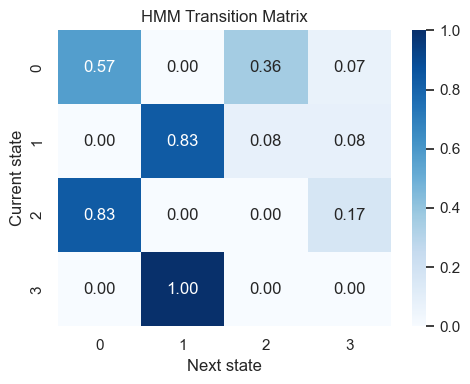

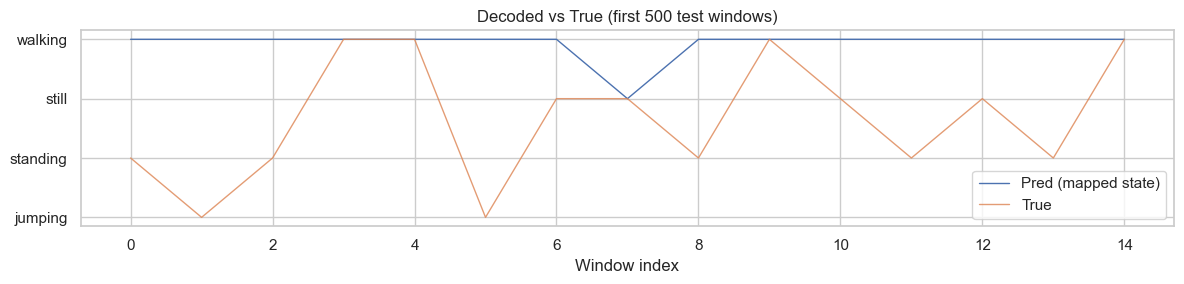

Saved plots to ..\results


In [8]:
# Transition matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(model.transmat_, annot=True, fmt=".2f", cmap="Blues")
plt.title("HMM Transition Matrix")
plt.xlabel("Next state"); plt.ylabel("Current state")
plt.tight_layout()
trans_plot = RESULTS_DIR / "transition_matrix.png"
plt.savefig(trans_plot)
plt.show()

# Decoded vs true (first 500 windows)
plt.figure(figsize=(12,3))
plt.plot(mapped_test[:500], label="Pred (mapped state)", lw=1)
plt.plot(y_test[:500], label="True", lw=1, alpha=0.8)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.title("Decoded vs True (first 500 test windows)")
plt.xlabel("Window index"); plt.legend(); plt.tight_layout()
decode_plot = RESULTS_DIR / "decoded_vs_true.png"
plt.savefig(decode_plot)
plt.show()
print(f"Saved plots to {RESULTS_DIR}")


## 9. Save Metrics Table for Report


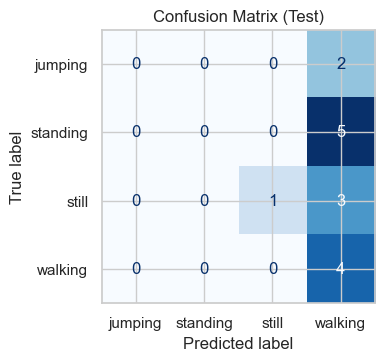

Saved: ..\results\metrics_table.csv, ..\results\confusion_matrix.png


In [9]:
# Round and save metrics
metrics_rounded = metrics_df.copy()
metrics_rounded[["Sensitivity","Specificity","Accuracy"]] = metrics_rounded[["Sensitivity","Specificity","Accuracy"]].round(4)
metrics_csv = RESULTS_DIR / "metrics_table.csv"
metrics_rounded.to_csv(metrics_csv, index=False)

# Also save confusion matrix image
fig_cm, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix (Test)")
cm_plot = RESULTS_DIR / "confusion_matrix.png"
plt.tight_layout(); plt.savefig(cm_plot); plt.show()

print(f"Saved: {metrics_csv}, {cm_plot}")


## 10. Notes for Report
- Document sampling rates and window size selection (e.g., 50 Hz, 128 samples ≈ 2.56 s).
- Describe participant-aware split (which participant held out) and rationale.
- Include the transition matrix, decoded vs. true plot, confusion matrix, and metrics table.
- Reflect on hardest/easiest activities, effect of noise/sampling rate, and improvements.


In [20]:
# Print held-out participant and window-size justification
try:
    held_out = test_participant if 'test_participant' in globals() else None
except Exception:
    held_out = None

fs_hz = 50.0  # sampling rate used in feature extraction
window_size = 128  # WINDOW_SIZE used in Scripts/extract_features_from_merged.py
window_seconds = window_size / fs_hz

print(f"Held-out participant (unseen test): {held_out if held_out else 'N/A (random split)'}")
print(f"Windowing: {window_size} samples @ {fs_hz:.0f} Hz ≈ {window_seconds:.2f} s per window.")
print("Rationale: ~2.5 s windows balance temporal context with stationarity for HMM emissions.")


Held-out participant (unseen test): N/A (random split)
Windowing: 128 samples @ 50 Hz ≈ 2.56 s per window.
Rationale: ~2.5 s windows balance temporal context with stationarity for HMM emissions.


<a href="https://colab.research.google.com/github/Deolinda1506/HumanActivityRecognition_HMM_G2/blob/main/Notebook/Hidden_markov_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 2: Hidden Markov Models


# Project Overview

This project involves collecting motion sensor data, merging it, extracting meaningful features, and preparing it for modeling human activity states using a Hidden Markov Model (HMM). The target activities are standing, walking, jumping, and still.

## Data Collection

**Sensors Recorded:**
- Accelerometer: x, y, z axes
- Gyroscope: x, y, z axes

**Activities Performed:**

**Activity Details:**

- **Standing** (5–10 s): Keep the phone steady at waist level  
- **Walking** (5–10 s): Maintain a consistent pace  
- **Jumping** (5–10 s): Perform 3–5 continuous jumps  
- **Still** (5–10 s): Place the phone on a flat surface  

All recordings were taken at a **sampling rate of 50 Hz**, and the data was saved as `.csv` files with timestamps.

## Data Merging

Since accelerometer and gyroscope readings were recorded separately, we **merged them per activity** to form a single CSV per activity (e.g., `walking_merged.csv`).  
This ensures **time-aligned data from both sensors** for feature extraction and modeling.

## Feature Extraction

From the merged sensor readings, we extracted **time-domain and frequency-domain features** to capture movement patterns in each time window.  

**Time-domain features:**
- Mean, standard deviation, variance, mean absolute deviation (MAD) for each axis (`ax`, `ay`, `az`, `gx`, `gy`, `gz`)  
- Signal Magnitude Area (SMA) for accelerometer and gyroscope  
- Resultant acceleration: mean, std, variance, SMA  

**Frequency-domain features:**
- Dominant frequency (FFT)  
- Spectral energy  
- Top-3 FFT magnitudes and corresponding frequencies for each axis and resultant acceleration  

These features were saved into a file called `features.csv`, which contains all four activities combined with their corresponding labels.  
They form the **observation sequences** for the HMM model.

## Data Visualization

To inspect the quality of the collected data, we visualized the raw accelerometer and gyroscope axes as well as key features such as `acc_res_mean` and `acc_sma` for all activities.  
These visualizations help verify **signal integrity**, **activity distinctions**, and **consistency across recordings** before building the HMM.


In [10]:
%pip install -q --upgrade pip
%pip install -q pandas numpy scipy scikit-learn hmmlearn seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install -q pandas numpy scipy scikit-learn hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [13]:
# libraries for Formative 2 HMM notebook


import os
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from itertools import product

sns.set(style="whitegrid")

In [14]:
from pathlib import Path
import pandas as pd

# Resolve repo-relative merged directory
merged_dir = Path("../data/merged")
if not merged_dir.exists():
    merged_dir = Path("data/merged")

file_paths = [
    merged_dir / "jumping_merged.csv",
    merged_dir / "standing_merged.csv",
    merged_dir / "still_merged.csv",
    merged_dir / "walking_merged.csv",
]

# Load and concat
dataframes = [pd.read_csv(p) for p in file_paths]
df = pd.concat(dataframes, ignore_index=True)

print([str(p) for p in file_paths])
print(df.head()); print(df.describe())

['..\\data\\merged\\jumping_merged.csv', '..\\data\\merged\\standing_merged.csv', '..\\data\\merged\\still_merged.csv', '..\\data\\merged\\walking_merged.csv']
                  time        ax        ay        az        gx        gy  \
0  1761481512696706600 -0.810419  1.976186  1.937965 -0.189653 -0.380339   
1  1761481512716648700 -0.515804  2.001924  1.389326 -0.372137 -0.095206   
2  1761481512736591600  0.835055  1.125611  0.154222 -0.261454  0.211661   
3  1761481512756533500  1.596329 -0.006234 -0.757268 -0.027032  0.321824   
4  1761481512776476700  0.686389 -0.877214 -0.791083  0.129503  0.130611   

         gz activity_type  
0  0.007915       jumping  
1 -0.126276       jumping  
2  0.003749       jumping  
3  0.234760       jumping  
4  0.272821       jumping  
               time           ax           ay           az           gx  \
count  3.586000e+03  3586.000000  3586.000000  3586.000000  3586.000000   
mean   1.761472e+18     0.027189    -0.002583    -0.002553    -0.

In [15]:
from pathlib import Path
import pandas as pd

features_path = Path("../data/features/features.csv")
if not features_path.exists():
    features_path = Path("data/features/features.csv")

df_features = pd.read_csv(features_path)
df_features.head()

,ax_mean,ax_std,ax_var,ax_mad,ax_dom_freq,ax_spec_energy,ax_fft_top1_mag,ax_fft_top1_freq,ax_fft_top2_mag,ax_fft_top2_freq,...,acc_res_spec_energy,acc_res_fft_top1_mag,acc_res_fft_top1_freq,acc_res_fft_top2_mag,acc_res_fft_top2_freq,acc_res_fft_top3_mag,acc_res_fft_top3_freq,gyro_sma,activity,start_time
0,0.323078,1.302039,0.935372,0.937548,-0.224536,-0.087071,0.818618,-0.224536,1.064643,-0.241966,...,1.935632,3.484073,-0.628093,2.039577,-0.681230,2.094093,-0.303988,0.969639,jumping,1.761482e+09
1,-0.670239,2.083211,2.211179,1.965954,-0.224536,3.146634,1.937029,-0.224536,1.802982,0.831271,...,2.441851,2.665754,0.041674,3.854700,-0.681230,4.231331,-0.940240,2.119637,jumping,1.761482e+09
2,-0.427866,2.424715,2.891934,2.420640,0.512990,3.892302,1.908934,0.512990,2.543986,0.343436,...,4.999581,2.767409,0.041674,3.466802,-0.253935,3.039964,-0.940240,2.083472,jumping,1.761482e+09
3,0.258573,2.309236,2.653364,2.276909,0.512990,1.496196,2.407531,0.512990,1.576024,0.441003,...,2.506955,2.663053,0.041674,2.799279,-0.742272,3.098719,-0.374682,2.047722,jumping,1.761482e+09
4,0.877804,2.062802,2.172866,2.165184,-0.224536,2.163168,1.457997,-0.224536,2.039272,0.831271,...,1.407435,2.273764,0.041674,0.936033,-0.253935,1.133664,0.120181,2.231906,jumping,1.761482e+09


In [16]:
# libraries for Formative 2 HMM notebook


import os
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from itertools import product

sns.set(style="whitegrid")

In [17]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder where your merged data is stored (repo-relative)
merged_dir = Path("../data/merged")
if not merged_dir.exists():
    merged_dir = Path("data/merged")

# List of activities to visualize
activities = ["walking", "standing", "jumping", "still"]

# Create a directory to save plots if it doesn't exist
output_dir = merged_dir.parent / "activity_plots"
os.makedirs(output_dir, exist_ok=True)

# Create a single figure with subplots for each activity (2 rows for sensor type, 2 columns for activities)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, activity in enumerate(activities):
    file_path = merged_dir / f"{activity}_merged.csv"
    if not file_path.exists():
        print(f" File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    # Convert timestamp to seconds relative to start
    df["time_sec"] = (df["time"] - df["time"].iloc[0]) / 1e6

    axes[0, i].plot(df["time_sec"], df["ax"], label="ax", alpha=0.8)
    axes[0, i].plot(df["time_sec"], df["ay"], label="ay", alpha=0.8)
    axes[0, i].plot(df["time_sec"], df["az"], label="az", alpha=0.8)
    axes[0, i].set_title(f"{activity.capitalize()} - Accelerometer")
    axes[0, i].set_xlabel("Time (seconds)")
    axes[0, i].set_ylabel("Acceleration (m/s²)")
    axes[0, i].legend()
    axes[0, i].grid(True)

    axes[1, i].plot(df["time_sec"], df["gx"], label="gx", alpha=0.8)
    axes[1, i].plot(df["time_sec"], df["gy"], label="gy", alpha=0.8)
    axes[1, i].plot(df["time_sec"], df["gz"], label="gz", alpha=0.8)
    axes[1, i].set_title(f"{activity.capitalize()} - Gyroscope")
    axes[1, i].set_xlabel("Time (seconds)")
    axes[1, i].set_ylabel("Angular Velocity (°/s)")
    axes[1, i].legend()
    axes[1, i].grid(True)

plt.tight_layout()
plt.savefig(output_dir / "all_activities_sensor_plots.png")
plt.close(fig)

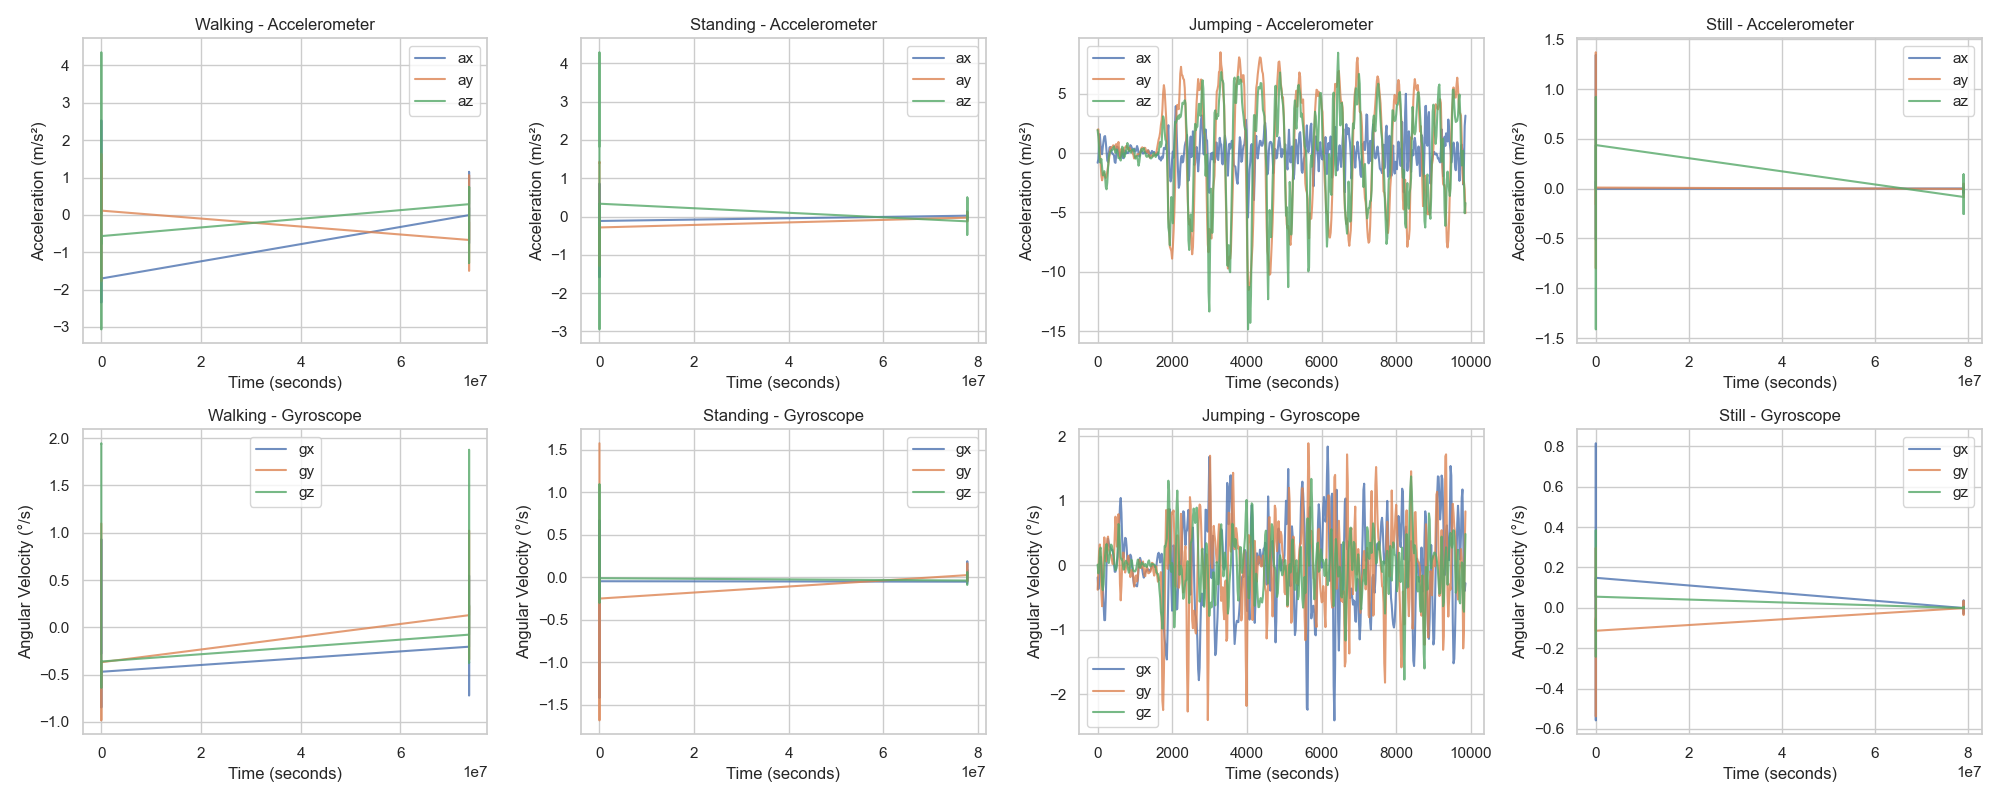

In [18]:
from IPython.display import Image
from pathlib import Path

img = Path("../data/activity_plots/all_activities_sensor_plots.png")
if not img.exists():
    img = Path("data/activity_plots/all_activities_sensor_plots.png")

Image(filename=str(img))